In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer, GPT2Model
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
learning_rate = 6e-4
sequence_len = 1024
batch_size = 8
gra_acc_steps = 8 * 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 64 * 2
eval_interval = 50

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

In [4]:
def precoss(data):
    re = {}
    for i in range(2):
        key = 'tokens_%s' % i
        re['input_ids_%s' % i] = data[key]['prefix'] + data[key]['completion']
        re['input_len_%s' % i] = len(re['input_ids_%s' % i])
        re['label'] = 0 if data['score_0'] > 0 else 1
    return re

dataset = load_dataset('openai/webgpt_comparisons', split='train')
dataset = dataset.map(precoss)\
.filter(lambda x: x['score_0'] != 0)\
.filter(lambda x: max(x['input_len_0'], x['input_len_1']) < sequence_len)
dataset.set_format(type='torch', device=device)
dataset

Dataset({
    features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1', 'input_ids_0', 'input_len_0', 'label', 'input_ids_1', 'input_len_1'],
    num_rows: 13218
})

In [5]:
print(tokenizer.decode(dataset[1]['input_ids_0'], skip_special_tokens=True))

Heterophobia is the irrational fear of what◼[1] Heterophobia (phobia.wikia.org)

Heterophobia, also known as sexophobia, is the fear of the opposite sex. The fear is caused by negative experiences with the opposite sex (such as being sexually assaulted), or even genetics and heredity. Heterophobes would avoid encountering people of opposite gender, that is, men should avoid women while women should avoid men. If the person of opposite sex contact the sufferers, symptoms may result, including breathlessness, dizziness, excessive sweating, nausea, dry mouth, feeling sick, shaking, coronary heart palpitations, inability to speak or assume clearly, a fear of dying (thanatophobia), turning into mad or dropping control, a sensation of detachment from actuality or a full blown anxiety attack. 

There are variety of methods of treating heterophobia◼ Heterophobia is the irrational fear of the opposite sex, coined as Sexophobia [1]. This phobia can be caused by genetics, heredity, negative exper

In [6]:
from torch.nn.utils.rnn import pad_sequence

def token_collect(batch):
    re = {}
    for i in range(2):
        ids = [data['input_ids_%s' % i] for data in batch]
        re['input_ids_%s' % i] = pad_sequence(ids, batch_first=True)
        re['input_len_%s' % i] = torch.stack([data['input_len_%s' % i] for data in batch])
    re['label'] = torch.stack([data['label'] for data in batch])
    return re

In [7]:
from torch.utils.data import DataLoader, random_split

train_set, test_set = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=token_collect)
test_loader = DataLoader(test_set, batch_size=3, shuffle=True, collate_fn=token_collect)
next(iter(train_loader))

{'input_ids_0': tensor([[ 5195,   466,   314,  ...,     0,     0,     0],
         [29054,    12,  9122,  ...,     0,     0,     0],
         [ 5195,   857,  2253,  ...,     0,     0,     0],
         ...,
         [  464,  6675, 17662,  ...,     0,     0,     0],
         [ 2437,   466,  9512,  ...,     0,     0,     0],
         [ 5195,   857,   352,  ...,    17,    60, 48366]], device='cuda:0'),
 'input_len_0': tensor([ 709,  668,  921,  810,  804,  906,  643, 1015], device='cuda:0'),
 'input_ids_1': tensor([[ 5195,   466,   314,  ...,     0,     0,     0],
         [29054,    12,  9122,  ...,     0,     0,     0],
         [ 5195,   857,  2253,  ...,     0,     0,     0],
         ...,
         [  464,  6675, 17662,  ...,  1382,   510, 48366],
         [ 2437,   466,  9512,  ...,     0,     0,     0],
         [ 5195,   857,   352,  ...,     0,     0,     0]], device='cuda:0'),
 'input_len_1': tensor([791, 651, 724, 691, 949, 983, 873, 275], device='cuda:0'),
 'label': tensor([0, 1

In [8]:
class RewardModel(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.embedding = model
        self.score = nn.Linear(model.embed_dim, 1, bias=False)

    def forward(self, x, seq_len):
        # x：表示文本，形状(B, T), seq_len：表示文本长度，形状(B)
        B, _ = x.shape
        emb = self.embedding(x).last_hidden_state  # (B, T, C)
        ind = torch.arange(B, device=seq_len.device)
        # 获取最后一个词元的特征
        pooled_emb = emb[ind, seq_len - 1]         # (B,    C)
        score = self.score(pooled_emb)             # (B,    1)
        return score

r_model = RewardModel(model)
r_model

RewardModel(
  (embedding): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=1, bias=False)
)

In [9]:
def print_trainable_parameters(model):
    """
    输出模型中可供训练的参数个数
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    trainable = f'trainable params: {trainable_params:,}'
    params = f'all params: {all_param:,}'
    percent = f'trainable%: {100 * trainable_params / all_param:.3f}'
    print(f'{trainable} || {params} || {percent}')

In [10]:
from peft import LoraConfig, PeftModel

config = LoraConfig(
    r=1,
    lora_alpha=8,
    target_modules=['c_attn'],
    lora_dropout=0.4,
    fan_in_fan_out=True,
    bias='none',
    modules_to_save=['score']
    )

r_model = PeftModel(r_model, config, adapter_name='lora')
print_trainable_parameters(r_model)

trainable params: 38,400 || all params: 124,478,208 || trainable%: 0.031


In [11]:
class PreferenceModel(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.pref = model

    def forward(self, data):
        input0, len0 = data['input_ids_0'], data['input_len_0']
        input1, len1 = data['input_ids_1'], data['input_len_1']
        score0 = self.pref(input0, len0)
        score1 = self.pref(input1, len1)
        out = torch.concat((score0, score1), dim=1)
        loss = F.cross_entropy(out, data['label'])
        return out, loss

p_model = PreferenceModel(r_model).to(device)
p_model

PreferenceModel(
  (pref): PeftModel(
    (base_model): LoraModel(
      (model): RewardModel(
        (embedding): GPT2Model(
          (wte): Embedding(50257, 768)
          (wpe): Embedding(1024, 768)
          (drop): Dropout(p=0.1, inplace=False)
          (h): ModuleList(
            (0-11): 12 x GPT2Block(
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (attn): GPT2Attention(
                (c_attn): Linear(
                  in_features=768, out_features=2304, bias=True
                  (lora_dropout): ModuleDict(
                    (lora): Dropout(p=0.4, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (lora): Linear(in_features=768, out_features=1, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (lora): Linear(in_features=1, out_features=2304, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
               

In [12]:
example = test_set[:1]
with torch.no_grad():
    p_model.eval()
    print(p_model(example), example['label'])
    print(r_model(example['input_ids_0'], example['input_len_0']))
    p_model.train()

(tensor([[ 0.8231, -2.1441]], device='cuda:0'), tensor(3.0173, device='cuda:0')) tensor([1], device='cuda:0')
tensor([[0.8231]], device='cuda:0')


In [13]:
from contextlib import nullcontext

def estimate_loss(model, ctx=nullcontext()):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader, ctx)
    re['test'] = _loss(model, test_loader, ctx)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader, ctx):
    """
    计算模型在不同数据集下面的评估指标
    """
    lossi = []
    data_iter= iter(data_loader)
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        with ctx:
            _, loss = model(data)
            lossi.append(loss.item())
    return torch.tensor(lossi).mean().item()

estimate_loss(p_model)

{'train': 0.9990766048431396, 'test': 1.0543365478515625}

In [14]:
# 参考自https://github.com/karpathy/nanoGPT/blob/master/train.py
import math

warmup_iters = 100
lr_decay_iters = 3000
min_lr = learning_rate / 10

def get_lr(it):
    # 1、线性预热
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2、超出lr_decay_iters，则返回min_lr
    if it > lr_decay_iters:
        return min_lr
    # 3、逐步衰减学习速率
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

In [15]:
grad_clip = 1.0

def train_reward_optimum(model, optimizer, data_loader, max_iters=1000):
    lossi = []
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
    data_iter = iter(data_loader)

    for iter_num in range(max_iters):
        # 动态调整学习率
        lr = get_lr(iter_num + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        for i in range(gra_acc_steps):
            data = next(data_iter, None)
            if data is None:
                data_iter = iter(data_loader)
                data = next(data_iter, None)
            # 混合进度训练
            ## 如果是用CPU进行计算，可能需要将dtype变成torch.bfloat16
            ## 当然如果使用CPU，需要非常长的时间
            ctx = torch.autocast(device_type=device, dtype=torch.float16)
            with ctx:
                _, loss = model(data)
                lossi.append(loss.item())
                loss *= 1 / gra_acc_steps
            scaler.scale(loss).backward()
        # 梯度裁剪
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if iter_num % eval_interval == 0:
            stats = estimate_loss(model, ctx)
            train_loss = f'train loss {stats["train"]:.4f}'
            eval_loss = f'test loss {stats["test"]:.4f}'
            print(f'step {iter_num:>4}: {train_loss}, {eval_loss}')
    return lossi

In [16]:
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
optimizer = optim.AdamW(p_model.parameters(), lr=learning_rate,
                        betas=(beta1, beta2), weight_decay=weight_decay)
l = train_reward_optimum(p_model, optimizer, train_loader, max_iters=1000)

step    0: train loss 1.0442, test loss 0.9501
step   50: train loss 0.6830, test loss 0.6951
step  100: train loss 0.6545, test loss 0.6703
step  150: train loss 0.6529, test loss 0.6690
step  200: train loss 0.6491, test loss 0.6514
step  250: train loss 0.6295, test loss 0.6609
step  300: train loss 0.6293, test loss 0.6686
step  350: train loss 0.6468, test loss 0.6415
step  400: train loss 0.6317, test loss 0.6807
step  450: train loss 0.6258, test loss 0.6348
step  500: train loss 0.6277, test loss 0.6426
step  550: train loss 0.6260, test loss 0.6535
step  600: train loss 0.6235, test loss 0.6457
step  650: train loss 0.6209, test loss 0.6771
step  700: train loss 0.6109, test loss 0.6656
step  750: train loss 0.6087, test loss 0.6395
step  800: train loss 0.6060, test loss 0.6544
step  850: train loss 0.5922, test loss 0.6524
step  900: train loss 0.6052, test loss 0.6679
step  950: train loss 0.5957, test loss 0.6456


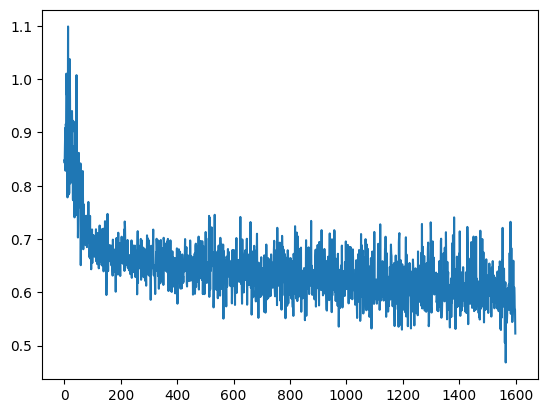

In [17]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [18]:
with torch.no_grad():
    p_model.eval()
    print(p_model(example), example['label'])
    print(r_model(example['input_ids_0'], example['input_len_0']))
    p_model.train()

(tensor([[2.9113, 2.4072]], device='cuda:0'), tensor(0.9766, device='cuda:0')) tensor([1], device='cuda:0')
tensor([[2.9113]], device='cuda:0')
